In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pickle
import torch
import io
import random
from gensim.models import Word2Vec

In [2]:
# function to work around loading a GPU generated pickle on local CPU machine
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# load synthesizer from saved object
#with open('models/TVAE_synthesizer_10emb_noCat_ageCat_0.1M.pkl', 'rb') as input:
#    synthesizer = CPU_Unpickler(input).load()

# modify device from cuda:0 to cpu
#synthesizer.device = 'cpu'

In [4]:
# load synthesizer from local machine
with open('models/TVAE_synthesizer_test.pkl', 'rb') as input:
    synthesizer = pickle.load(input)

In [5]:
# check out sample
N = 20000
sample = synthesizer.sample(N)
np.set_printoptions(suppress = True, precision = 2)

In [6]:
df_input = pd.read_csv('data/cc_data_input_10emb_ageCat.csv')

In [7]:
input_columns = list(df_input.columns)[1:]

In [8]:
df_sample = pd.DataFrame(sample, columns=input_columns) 
pd.set_option('display.max_columns', 36)
df_sample.head()

,Purchase Amount,Account Type_bank_account,Account Type_credit_card,Consumer Gender_female,Consumer Gender_male,SIC Description_Book Stores,"SIC Description_Communications Services, Not Elsewhere Classified",SIC Description_Drug Stores and Proprietary Stores,SIC Description_Eating Places,SIC Description_Family Clothing Stores,SIC Description_Gasoline Service Stations,SIC Description_Grocery Stores,SIC Description_Miscellaneous Food Stores,SIC Description_Other,SIC Description_Taxicabs,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,...,"Age Range_(30, 35]","Age Range_(35, 40]","Age Range_(40, 45]","Age Range_(45, 50]","Age Range_(50, 55]","Age Range_(55, 60]","Age Range_(60, 65]","Age Range_(65, 70]",retailerVec_01,retailerVec_02,retailerVec_03,retailerVec_04,retailerVec_05,retailerVec_06,retailerVec_07,retailerVec_08,retailerVec_09,retailerVec_10
0,11.541271,0.000815,0.998693,0.999381,0.001145,-0.000022,0.000058,-0.000119,-0.000361,-0.000012,-0.000139,0.000156,0.000059,0.998620,0.000051,-0.000291,0.000071,-0.000407,...,0.000043,0.000011,-0.000319,0.000135,-0.000018,0.000023,0.000077,0.000030,2.155286,0.409130,-0.232454,-0.588956,1.194569,-1.124639,2.736307,-5.518124,-3.486201,0.728872
1,19.102873,-0.000122,0.999461,0.999720,0.000493,0.000184,0.000097,0.000050,-0.000402,0.000114,-0.000283,0.000019,0.000063,0.000685,-0.000087,0.000123,0.000272,0.000002,...,-0.000259,-0.000460,0.000227,0.000037,-0.000293,0.000082,-0.000055,0.000028,1.868813,-0.696809,-1.385684,1.735155,-2.517284,-2.525409,-1.355929,-2.476657,-2.304707,-0.325269
2,6.873021,1.000995,-0.000217,0.999775,0.000292,0.000099,0.000017,-0.000045,0.000048,0.000132,-0.000302,0.998349,-0.000046,0.000005,0.000050,-0.000152,0.000492,0.000350,...,0.000162,0.000084,0.000326,-0.000077,-0.000170,0.000009,0.000089,-0.000018,0.171353,-1.173427,-0.844995,0.114030,0.193321,-2.539412,-0.657793,-1.412820,-0.883119,-0.663079
3,7.708029,0.001141,0.999228,0.999428,0.000030,0.000251,-0.000007,0.000031,-0.000361,-0.000110,-0.000181,0.000006,0.000037,1.000171,0.000063,0.000274,0.000076,-0.000052,...,-0.000126,-0.000073,0.000201,-0.000132,-0.000200,0.000104,-0.000105,0.000027,0.480481,-1.405797,0.392334,1.010379,-1.441026,0.843244,-1.498253,-5.380883,-4.143547,0.556895
4,1.905554,0.999121,-0.000751,-0.000426,1.000283,0.000100,-0.000001,0.000080,0.000152,-0.000034,-0.000029,0.000054,-0.000125,0.000092,0.000045,0.000020,0.000054,0.000215,...,-0.000184,-0.000170,0.000119,-0.000108,0.000288,0.000123,0.000140,-0.000008,1.237051,-0.633912,-1.598125,1.469832,-2.534529,-2.406259,-1.288502,-2.288167,-2.087515,-0.096629


In [9]:
# return series of dummy variables with given column name
def reverse_dummy(df, col_name):
    # get index of columns that starts with col_name, for example, Gender_male, Gender_female for col_name = `Gender`
    idx = [i for i, s in enumerate(list(df.columns)) if col_name in s]
    tmp = df.iloc[:,idx]
    # find column name for max in each row and put into one series
    df_output = pd.Series(tmp.idxmax(axis=1), name = col_name)
    
    # remove strings with col_name plus underscore
    df_output = df_output.map(lambda x: x.replace(col_name + '_',''))
    return df_output

In [10]:
df_purchase = df_sample.iloc[:,[0]]
df_age = reverse_dummy(df_sample,'Age Range')
df_account = reverse_dummy(df_sample,'Account Type')
df_gender = reverse_dummy(df_sample,'Consumer Gender')
df_SIC = reverse_dummy(df_sample,'SIC Description')
df_dw = reverse_dummy(df_sample,'day_of_week')
df_pm = reverse_dummy(df_sample,'period_of_month')

In [11]:
df_reverse = pd.concat([df_purchase,df_age,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)

# remove negative purchase amount
df_reverse = df_reverse[(df_reverse['Purchase Amount'] > 0)]
df_reverse.reset_index(drop=True, inplace=True)

#pd.set_option('display.max_rows', N)
print(df_reverse.shape)
df_reverse.head()

(18877, 7)


,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month
0,11.541271,"(25, 30]",credit_card,female,Other,Sunday,end
1,19.102873,"(25, 30]",credit_card,female,Other,Monday,end
2,6.873021,"(40, 45]",bank_account,female,Grocery Stores,Monday,start
3,7.708029,"(25, 30]",credit_card,female,Other,Wednesday,end
4,1.905554,"(50, 55]",bank_account,male,Eating Places,Sunday,mid


In [12]:
def return_age(age_range):
    age_range = age_range.replace('(','').replace(']','').replace(' ','')
    r1 = int(age_range.split(',')[0])
    r2 = int(age_range.split(',')[1])
    return random.choice(list(range(r1+1, r2+1)))

In [13]:
df_reverse['Age'] = df_reverse.apply(lambda x: return_age(x['Age Range']), axis = 1)
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age
0,11.541271,"(25, 30]",credit_card,female,Other,Sunday,end,29
1,19.102873,"(25, 30]",credit_card,female,Other,Monday,end,28
2,6.873021,"(40, 45]",bank_account,female,Grocery Stores,Monday,start,42
3,7.708029,"(25, 30]",credit_card,female,Other,Wednesday,end,26
4,1.905554,"(50, 55]",bank_account,male,Eating Places,Sunday,mid,52


In [14]:
#df_reverse['SIC Description'].value_counts().index.to_list()

In [15]:
# reverse retailerVec back to retailers
idx = [i for i, s in enumerate(list(df_sample.columns)) if 'retailerVec' in s]
df_retailerVec = df_sample.iloc[:,idx]

# load the retailer_map
with open('models/retailer_map.pkl', 'rb') as input:
    retailer_map = pickle.load(input)    

model = Word2Vec.load('models/perSICperPerson_10emb.model')
    
# only keep values in the model (more than 5 times appearance)
for key, value in retailer_map.items():
    retailer_map[key] = list(set(value) & set(model.wv.vocab))
    
# group other SIC (after top N) into other
list2keep = ['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified']
other_list = []    
for key, value in retailer_map.items():
    if key not in list2keep:
        other_list = other_list + value

# delete other group key-values in retailer_map
retailer_map_grouped = {k: retailer_map[k] for k in list2keep}

# add other key-value pairs
retailer_map_grouped['Other'] = other_list

# put retailer vectors into one column
df_retailerVec['retailerVec']= df_retailerVec.values.tolist()
df_SIC_vector = pd.concat([df_SIC,df_retailerVec['retailerVec']],axis = 1)
df_SIC_vector.head()

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SIC Description,retailerVec
0,Other,"[2.155286013033253, 0.4091295431669427, -0.232..."
1,Other,"[1.868813020971084, -0.6968093476251656, -1.38..."
2,Grocery Stores,"[0.17135328551108686, -1.1734267043959687, -0...."
3,Other,"[0.48048093652835777, -1.4057968010472726, 0.3..."
4,Eating Places,"[1.237051210953297, -0.6339122833185209, -1.59..."


In [16]:
retailer_map_grouped.keys()
#retailer_map_grouped['Radiotelephone Communications']
#df_SIC_vector['SIC Description'].value_counts()

dict_keys(['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified', 'Other'])

In [17]:
# find out retailer in the same SIC and also with the most similar vector
def return_retailer_SIC(model, retailer_map_grouped, sector, vector):
    if pd.isnull(sector):
        return None
    else:
        word_list = retailer_map_grouped[sector]
        min_idx = model.wv.distances(vector, other_words = word_list).argmin()
        return word_list[min_idx]

In [18]:
df_reverse['Normalized Retailer'] = df_SIC_vector.apply(lambda x: return_retailer_SIC(model, retailer_map_grouped, x['SIC Description'],x['retailerVec']), axis = 1)
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer
0,11.541271,"(25, 30]",credit_card,female,Other,Sunday,end,29,Wine Rack
1,19.102873,"(25, 30]",credit_card,female,Other,Monday,end,28,Spotless Dry Clearners
2,6.873021,"(40, 45]",bank_account,female,Grocery Stores,Monday,start,42,E Park
3,7.708029,"(25, 30]",credit_card,female,Other,Wednesday,end,26,Canadian Tire Store
4,1.905554,"(50, 55]",bank_account,male,Eating Places,Sunday,mid,52,Olly Fresco's


In [19]:
# given period_of_month (start, mid or end) and year (1989) and month (6), return index of the possible days
def return_day_index(period_of_month, year, month):
    if period_of_month == 'start':
        return list(range(1,11))
    elif period_of_month == 'mid':
        return list(range(11,21))
    else:
        return list(range(21, pd.Period(str(year) + '-' + str(month)).days_in_month + 1))
    
# function to convert day_of_week and period_of_month back to Date, given a year and a month
# Example:
# input: day_of_week = 'Monday'; period_of_month = 'start'; Y = 2020; M = 2
# output: 2020-02-03 00:00:00

def return_date(day_of_week, period_of_month, Y, M):
    # return list of days
    D = return_day_index(period_of_month, Y, M)

    tmp = pd.DataFrame({'year': [str(Y) for i in range(len(D))],
                        'month': [str(M) for i in range(len(D))],
                        'day': D})
    
    # create table with each row of year, month and day in given period
    date_period = pd.to_datetime(tmp[['year', 'month', 'day']])

    # locate index of which date is the given day_of_week
    idx_list = [i for i, s in enumerate(date_period.dt.strftime('%A')) if day_of_week in s]

    # randomly pick up one index, since it's possible one period has multiple given weekday (say Monday)
    idx = random.choice(idx_list)

    return date_period[idx]

In [20]:
Y = 2022; M = 2
df_reverse['Transaction Date'] = df_reverse.apply(lambda x: return_date(x.day_of_week, x.period_of_month, Y, M), axis = 1)
#df_reverse.drop(['day_of_week','period_of_month'], axis = 1, inplace = True, errors = 'ignore')
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer,Transaction Date
0,11.541271,"(25, 30]",credit_card,female,Other,Sunday,end,29,Wine Rack,2022-02-27
1,19.102873,"(25, 30]",credit_card,female,Other,Monday,end,28,Spotless Dry Clearners,2022-02-21
2,6.873021,"(40, 45]",bank_account,female,Grocery Stores,Monday,start,42,E Park,2022-02-07
3,7.708029,"(25, 30]",credit_card,female,Other,Wednesday,end,26,Canadian Tire Store,2022-02-23
4,1.905554,"(50, 55]",bank_account,male,Eating Places,Sunday,mid,52,Olly Fresco's,2022-02-20


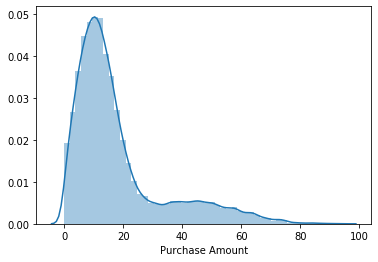

In [21]:
sns.distplot(df_reverse['Purchase Amount']);
#plt.savefig('figs/eda/purchase_hist_syn.png',bbox_inches='tight')

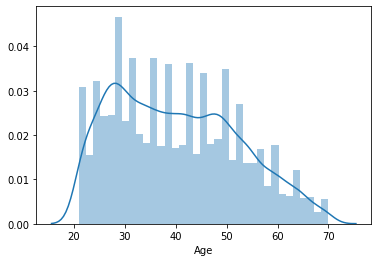

In [22]:
sns.distplot(df_reverse['Age']);
#plt.savefig('figs/eda/age_hist_syn.png',bbox_inches='tight')

In [23]:
# view counts and percentage for each column's elements
def view_column_counts(df, col_name):
    df_pivot = df.groupby(by = col_name).size().reset_index(name='Counts')
    df_pivot['Per (%)'] = (df_pivot['Counts'])/df.shape[0]*100
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    return df_pivot

In [24]:
# gender, account type, sector and retailer percentage
text_col_list = ['Account Type', 'Consumer Gender','Normalized Retailer', 'SIC Description']

for col_name in text_col_list:   
    print(col_name)
    df_pivot = view_column_counts(df_reverse,col_name)
    print(df_pivot)
    print('\n')

Account Type
   Account Type  Counts    Per (%)
0  bank_account   13052  69.142343
1   credit_card    5825  30.857657


Consumer Gender
  Consumer Gender  Counts    Per (%)
0          female   16679  88.356201
1            male    2198  11.643799


Normalized Retailer
         Normalized Retailer  Counts    Per (%)
551              Tim Hortons    2440  12.925783
586                  Walmart    1810   9.588388
400             Petro-Canada    1443   7.644223
327               McDonald's    1317   6.976744
11                    Amazon     705   3.734704
..                       ...     ...        ...
444             Reid's Dairy       1   0.005297
282               Lands' End       1   0.005297
280       La Luna Restaurant       1   0.005297
166              Fabricville       1   0.005297
73   Bulk Barn Foods Limited       1   0.005297

[612 rows x 3 columns]


SIC Description
                                     SIC Description  Counts    Per (%)
3                                      Ea

barplot for SIC Description


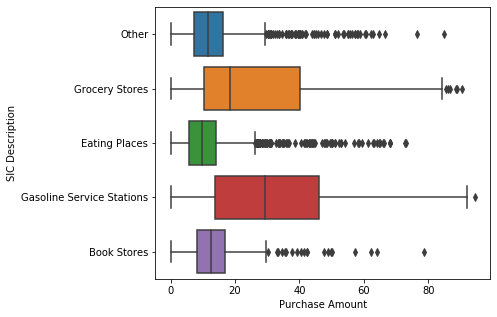

barplot for Normalized Retailer


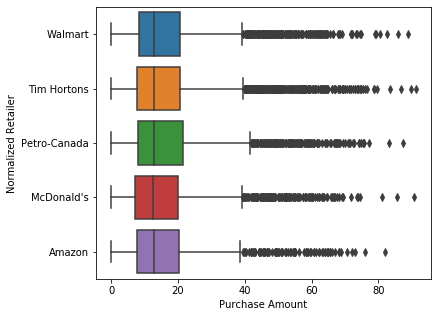

In [25]:
check_list = ['SIC Description','Normalized Retailer']
fig_dims = [6, 5] 
N = 5
threshold = 100

for cat in check_list:   
    print("barplot for %s" % (cat))
    list_tmp = df_reverse[cat].value_counts()[:N].index.tolist() # top N counts in that category
    df_tmp = df_reverse[df_reverse[cat].isin(list_tmp) & (df_reverse['Purchase Amount'] < threshold)]
    fig, ax = plt.subplots(figsize = fig_dims)
    chart = sns.boxplot(y = df_tmp[cat], x = df_tmp['Purchase Amount'])
    plt.show()